# Librerías a utilizar

###### En este código se lleva a cabo un análisis comparativo entre un modelo de Naive bayes, XGBoost y un ADAboost para determinar cual se ajusta mejor para predecir correos phishing.

In [4]:
import pandas as pd
import numpy as np
import os, shutil
import xgboost as xg
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay

# Carga y exploracion de datos

In [5]:
import kagglehub

# Download latest version
pathd = kagglehub.dataset_download("ethancratchley/email-phishing-dataset")

print("Path to dataset files:", pathd)

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\brand\.cache\kagglehub\datasets\ethancratchley\email-phishing-dataset\versions\1


In [6]:
# Ruta destino
dest_folder = "C:/DB/email-phishing-dataset"
dest_file = os.path.join(dest_folder, "email_phishing_data.csv")

# Crear carpeta de destino si no existe
os.makedirs(dest_folder, exist_ok=True)

# Ruta del archivo descargado
source_file = os.path.join(pathd, "email_phishing_data.csv")

# Mover archivo si no existe ya en destino
if not os.path.exists(dest_file):
    shutil.move(source_file, dest_file)

    print("Archivo movido exitosamente.")
else:
    print("El archivo ya existe en la carpeta destino.")

El archivo ya existe en la carpeta destino.


In [7]:
data = pd.read_csv(dest_file)
data.head(10)

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0
5,37,29,5,0,0,3,7,1,0
6,4,4,1,0,0,0,0,0,0
7,22,21,4,4,1,0,7,0,0
8,289,176,66,0,0,3,28,2,0
9,32,30,9,0,0,0,2,0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB


In [9]:
data[data.duplicated()==True]

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
12,923,355,309,0,0,0,51,0,0
14,5,5,1,0,0,0,0,0,0
25,1400,505,546,0,0,5,35,1,0
49,803,376,335,0,0,4,21,0,0
55,803,376,335,0,0,4,21,0,0
...,...,...,...,...,...,...,...,...,...
524817,28,22,0,0,0,0,5,0,0
524831,16,14,3,0,0,0,1,0,0
524837,48,37,20,0,0,0,0,0,0
524843,61,46,11,0,0,0,3,0,0


In [10]:
#Eliminamos los registros duplicados 
data1 = data.drop_duplicates()
data1.shape

(205052, 9)

In [11]:
# Verificamos que no tengamos registros duplicados
data1[data1.duplicated() == True]

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label


# Ajuste de modelos

In [12]:
# Identificamos la variable objetivo
seed = 1995
CV = KFold(10, shuffle = True,random_state = seed)
x = data1.drop(columns = ['label'])
y = data1['label'] # Variable objetivo

# Dividmos los datos para validación
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = .2,random_state = seed)

In [13]:
# Crear instancias de los modelos a evaluar para ajustar
XGB_model = xg.XGBClassifier(random_state = seed)
ADA_model = RandomForestClassifier(random_state = seed)

In [14]:
# Seleción de características óptimas por modelo
Feature_XGB = RFECV(XGB_model,step = 1, cv = CV).fit(x_train,y_train)
Feature_ADA = RFECV(ADA_model,step = 1, cv = CV).fit(x_train,y_train)

In [15]:
print(f'F_XGB = {Feature_XGB.get_feature_names_out()}\nF_ADA = {Feature_ADA.get_feature_names_out()}')

F_XGB = ['num_words' 'num_unique_words' 'num_stopwords' 'num_links'
 'num_unique_domains' 'num_email_addresses' 'num_spelling_errors'
 'num_urgent_keywords']
F_ADA = ['num_words' 'num_unique_words' 'num_stopwords' 'num_links'
 'num_email_addresses' 'num_spelling_errors' 'num_urgent_keywords']


In [16]:
#Nos quedamos con las características más importantes detectadas
x_xgb =  x_train.loc[:,Feature_XGB.get_feature_names_out()]
x_ada =  x_train.loc[:,Feature_ADA.get_feature_names_out()]
x_xgb_test = x_test.loc[:,Feature_XGB.get_feature_names_out()]
x_ada_test = x_test.loc[:,Feature_ADA.get_feature_names_out()]

In [17]:
# Revisión de los parámetros de cada modelo
print(f'XGB_params = {XGB_model.get_params().keys()}\nADA_params = {ADA_model.get_params().keys()}')

XGB_params = dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])
ADA_params = dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm

In [18]:
#Definimos los diccionarios de los parámetros a probar para cada modelo
space_params_XGB = {"n_estimators" : [20, 50, 100],
                    "max_depth" : [3, 6, 9],
                    "learning_rate" : [0.001, 0.01, 0.1, 1]
                    }
space_params_ADA = {"n_estimators" : [20, 50, 100],
                    "max_depth" : [3, 6, 9],
                    }

In [19]:
xgb_grid = GridSearchCV(estimator = XGB_model, 
                        param_grid = space_params_XGB, 
                        scoring = ['f1'],
                        refit = 'f1',
                        cv = CV)
xgb_grid.fit(x_xgb,y_train)

xgb_grid.best_params_
# 102m minutos de tiempo de ejecución

{'learning_rate': 1, 'max_depth': 9, 'n_estimators': 100}

In [20]:
# Entrenamiento con el modelo óptimo
XGB_Final_model = xg.XGBClassifier(learning_rate = 1, max_depth = 6, n_estimators = 500,random_state = seed).fit(x_xgb,y_train)
predic = XGB_Final_model.predict(x_xgb_test)

f1 = f1_score(y_test,predic)
pres = precision_score(y_test,predic)
recall = recall_score(y_test,predic)
auc = roc_auc_score(y_test,predic)
accuracy = accuracy_score(y_test,predic)
print(f'f1:{f1}\nprecision:{pres}\nrecall:{recall}\nauc:{auc}\naccuracy:{accuracy}')

f1:0.3114487249050461
precision:0.4743801652892562
recall:0.23182552504038773
auc:0.6119150756471896
accuracy:0.9690570822462267


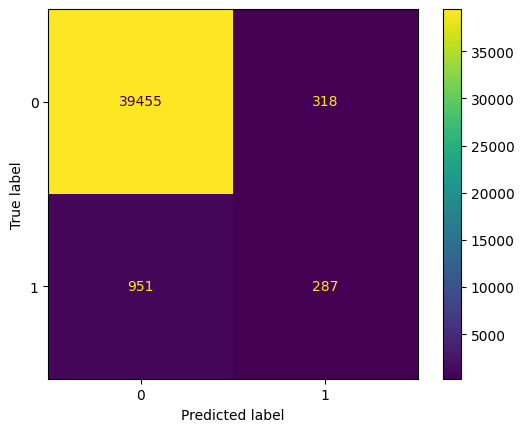

In [21]:
cm_xgb = confusion_matrix(y_test,predic, labels = XGB_Final_model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = XGB_Final_model.classes_)
display.plot()

In [22]:
ada_grid = GridSearchCV(estimator = ADA_model, 
                        param_grid = space_params_ADA, 
                        scoring = ['f1'],
                        refit = 'f1',
                        cv = CV)
ada_grid.fit(x_ada,y_train)

ada_grid.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [23]:
# Entrenamiento con el modelo óptimo
ADA_Final_model = RandomForestClassifier(n_estimators = 100,max_depth = 9,random_state = seed).fit(x_ada,y_train)
predic = ADA_Final_model.predict(x_ada_test)

f1 = f1_score(y_test,predic)
pres = precision_score(y_test,predic)
recall = recall_score(y_test,predic)
auc = roc_auc_score(y_test,predic)
accuracy = accuracy_score(y_test,predic)
print(f'f1:{f1}\nprecision:{pres}\nrecall:{recall}\nauc:{auc}\naccuracy:{accuracy}')

f1:0.05498821681068342
precision:1.0
recall:0.02827140549273021
auc:0.5141357027463651
accuracy:0.9706664065738461


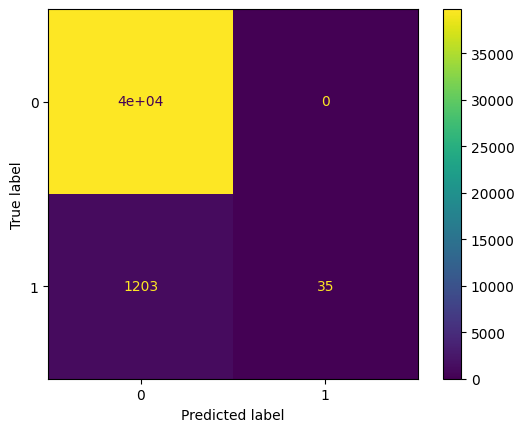

In [24]:
cm_ada = confusion_matrix(y_test,predic,labels = ADA_Final_model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm_ada, display_labels = ADA_Final_model.classes_)
display.plot()

###### De lo anterior podemos observar que el xgboost tiene un mejor rendimeinto que el random forest, sin embargo, sigue sin presentar métricas satisfactorias para enfrentar el problema. Abajo se mostrará de igual manera las configuraciones de hiperparámetros explorados ya que de ahí podemos obtener buena información sobre los parámetros elegidos y se podrá elegir alguna otra configuración con una mejor "relación calidad-precio".

In [25]:
XGB_train_info = pd.DataFrame(xgb_grid.cv_results_)
XGB_train_info.sort_values(by = 'mean_test_f1',ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1
35,0.780756,0.032240,0.032095,0.002022,1.0,9,100,"{'learning_rate': 1, 'max_depth': 9, 'n_estima...",0.309013,0.298050,0.289157,0.264416,0.308782,0.298667,0.314244,0.309064,0.262295,0.291971,0.294566,0.017388,1
34,0.442238,0.010116,0.024521,0.001535,1.0,9,50,"{'learning_rate': 1, 'max_depth': 9, 'n_estima...",0.275148,0.285714,0.269886,0.260741,0.292035,0.278552,0.285285,0.307220,0.266667,0.276596,0.279784,0.012783,2
32,0.558741,0.015390,0.026024,0.001736,1.0,6,100,"{'learning_rate': 1, 'max_depth': 6, 'n_estima...",0.257274,0.263400,0.291176,0.257669,0.274268,0.270504,0.280757,0.289855,0.260163,0.280431,0.272550,0.012145,3
33,0.235461,0.004668,0.019213,0.001715,1.0,9,20,"{'learning_rate': 1, 'max_depth': 9, 'n_estima...",0.270270,0.243370,0.272328,0.242424,0.283048,0.280000,0.279435,0.292763,0.257002,0.267913,0.268855,0.015852,4
31,0.326857,0.012342,0.021510,0.002073,1.0,6,50,"{'learning_rate': 1, 'max_depth': 6, 'n_estima...",0.260188,0.243902,0.262595,0.230894,0.265802,0.259701,0.280528,0.267581,0.245734,0.242812,0.255974,0.014009,5


In [26]:
ADA_train_info = pd.DataFrame(ada_grid.cv_results_)
ADA_train_info.sort_values(by = 'mean_test_f1', ascending = False ).head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1
8,11.977304,1.087350,0.162865,0.009801,9,100,"{'max_depth': 9, 'n_estimators': 100}",0.024742,0.036364,0.023392,0.040000,0.059642,0.040816,0.048583,0.056277,0.051173,0.052525,0.043351,0.011901,1
7,6.177305,0.577612,0.092545,0.022110,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.024742,0.036364,0.027237,0.036000,0.059642,0.037175,0.048485,0.047826,0.047109,0.044534,0.040911,0.010073,2
6,2.191418,0.045049,0.040080,0.001864,9,20,"{'max_depth': 9, 'n_estimators': 20}",0.016563,0.028398,0.027184,0.032129,0.051896,0.048059,0.048485,0.052061,0.042735,0.032587,0.038010,0.011648,3
3,1.740481,0.105349,0.030288,0.003533,6,20,"{'max_depth': 6, 'n_estimators': 20}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008734,0.000000,0.000873,0.002620,4
5,7.995458,0.143668,0.103644,0.004399,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008734,0.000000,0.000873,0.002620,4


###### Finalmente probaremos otro modelo que podría detectar los correos fraudulentos y se someterá a las mismas métricas de valuación.

# Probando un modelo Naive Bayes 

In [29]:
Naive = BernoulliNB()
Naive_selector = SelectKBest(score_func = chi2)

In [32]:
Naive.get_params().keys()

dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior', 'force_alpha'])

In [ ]:
# Seleccionamos las mejores características para el modelo
Feature_Naive = Naive_selector.fit(x_train,y_train).get_feature_names_out()
Feature_Naive

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


array(['num_words', 'num_unique_words', 'num_stopwords', 'num_links',
       'num_unique_domains', 'num_email_addresses', 'num_spelling_errors',
       'num_urgent_keywords'], dtype=object)

In [34]:
x_naive = x_train.loc[:,Feature_Naive]
x_naive_test = x_test.loc[:,Feature_Naive]
Naive.fit(x_naive,y_train)

BernoulliNB()

In [35]:
predic_Naive = Naive.predict(x_naive_test)
#Métricas 
f1 = f1_score(y_test,predic_Naive)
recall = recall_score(y_test,predic_Naive)
precision = precision_score(y_test,predic_Naive)
AUC = roc_auc_score(y_test,predic_Naive)
accuracy = accuracy_score(y_test,predic_Naive)
print(f'f1:{f1}\nprecision:{pres}\nrecall:{recall}\nauc:{auc}\naccuracy:{accuracy}')

f1:0.0
precision:1.0
recall:0.0
auc:0.5141357027463651
accuracy:0.9698129770061691


C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


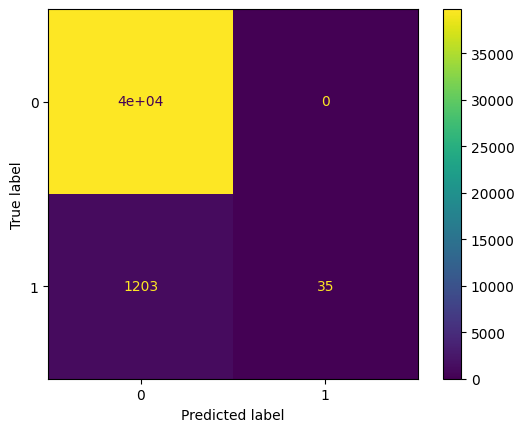

In [36]:
cm = confusion_matrix(y_test,predic,labels = Naive.classes_)
display = ConfusionMatrixDisplay(cm,display_labels = Naive.classes_)
display.plot()